In [1]:
import sys
import os
import numpy as np
import json

from sklearn.model_selection import train_test_split
import pandas as pd

import tensorflow as tf
import keras.backend.tensorflow_backend as K
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Activation, LSTM, CuDNNGRU, CuDNNLSTM
from keras.layers import Dropout, Conv1D, MaxPooling1D, GlobalMaxPool1D
from keras.layers import Bidirectional, InputLayer

from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
tf.set_random_seed(201)
np.random.seed(201)

## 데이터 로드

In [3]:
DATA_IN_PATH = './data/word_dict/'
DATA_OUT_PATH = './data_out/'
#INPUT_TRAIN_DATA = 'input.npy'
#LABEL_TRAIN_DATA = 'label.npy'
#DATA_CONFIGS = 'data_configs.json'

INPUT_TRAIN_DATA = 'pos_input.npy'
LABEL_TRAIN_DATA = 'pos_label.npy'
DATA_CONFIGS = 'pos_data_configs.json'

input_data = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
label_data = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r',  -1, "utf-8"))

In [4]:
TEST_SPLIT = 0.2
RND_SEED = 0
VOCAB_SIZE = prepro_configs['vocab_size']+1
EMB_SIZE = 128
BATCH_SIZE = 512
MAX_LEN = 200

In [5]:
train_input, eval_input, train_label, eval_label = train_test_split(input_data,
                                                                    label_data,
                                                                    test_size=TEST_SPLIT,
                                                                    random_state=RND_SEED)

In [6]:
train_input = sequence.pad_sequences(train_input, maxlen=MAX_LEN)
eval_input = sequence.pad_sequences(eval_input, maxlen=MAX_LEN)

## 모델 설정

In [7]:
def Model():
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 128, input_length=MAX_LEN))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 3, padding='same', kernel_initializer='he_normal', activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(250))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [8]:
model = Model()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          2099712   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 32)           12320     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               8250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
__________________________

In [9]:
# 최선의 모델 model 저장
MODEL_PATH = './model/'
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

model_full_path = MODEL_PATH + 'best_train_model.hdf5'

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min')
check_point = ModelCheckpoint(filepath=model_full_path, monitor='val_loss', verbose=1, save_best_only=True)

In [11]:
with K.tf_ops.device('/device:GPU:0'):
    hist = model.fit(train_input, train_label, batch_size = BATCH_SIZE,
                     epochs = 10, validation_split = 0.2, callbacks=[early_stopping, check_point])


Train on 5944 samples, validate on 1486 samples
Epoch 1/10
5944/5944 [==============================] - 2s 371us/step - loss: 0.5882 - accuracy: 0.7340 - val_loss: 0.5228 - val_accuracy: 0.7833

Epoch 00001: val_loss improved from inf to 0.52282, saving model to ./model/best_train_model.hdf5
Epoch 2/10
5944/5944 [==============================] - 0s 20us/step - loss: 0.5495 - accuracy: 0.7710 - val_loss: 0.5375 - val_accuracy: 0.7833

Epoch 00002: val_loss did not improve from 0.52282


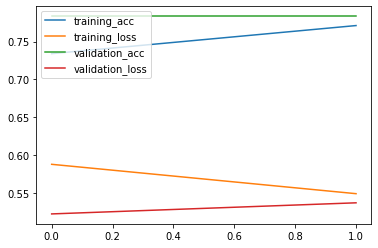

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['val_loss'])
plt.legend(['training_acc', 'training_loss','validation_acc', 'validation_loss'], loc = 'upper left')
plt.show()

In [13]:
model.load_weights(model_full_path)
results = model.evaluate(eval_input, eval_label)
print('Test accuracy: ', results[1])

1858/1858 [==============================] - 0s 68us/step
Test accuracy:  0.7814854979515076


## K-fold validation 사용 

In [14]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=20, random_state=RND_SEED, shuffle=True)

for train_index, test_index in kf.split(input_data):
    X_train, X_test = input_data[train_index], input_data[test_index]
    y_train, y_test = label_data[train_index], label_data[test_index]
    
X_train = sequence.pad_sequences(X_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LEN)

In [15]:
model = Model()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          2099712   
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 32)           12320     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               8250      
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min')

In [17]:
with K.tf_ops.device('/device:GPU:0'):
    hist = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = 5)

Epoch 1/5
8824/8824 [==============================] - 0s 42us/step - loss: 0.5756 - accuracy: 0.7407
Epoch 2/5
8824/8824 [==============================] - 0s 19us/step - loss: 0.5356 - accuracy: 0.7736
Epoch 3/5
8824/8824 [==============================] - 0s 18us/step - loss: 0.5145 - accuracy: 0.7736
Epoch 4/5
8824/8824 [==============================] - 0s 19us/step - loss: 0.4253 - accuracy: 0.7965
Epoch 5/5
8824/8824 [==============================] - 0s 18us/step - loss: 0.2581 - accuracy: 0.8901


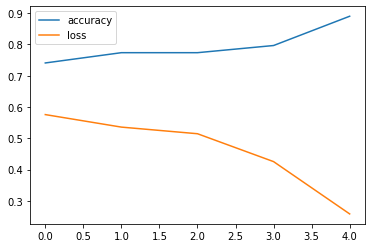

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.legend(['accuracy', 'loss'], loc = 'upper left')
plt.show()

In [19]:
score = model.evaluate(X_test,y_test)
print('Test accuracy: ', score[1])

464/464 [==============================] - 0s 271us/step
Test accuracy:  0.8706896305084229
